In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Code_Injection_Dataset

/content/drive/MyDrive/Code_Injection_Dataset


In [ ]:
df_train = pd.read_csv('dataset_capec_combine.csv')
df_train.head()

,text,label
0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal


242 - Code Injection                      261885
000 - Normal                              226509
194 - Fake the Source of Data              55982
34 - HTTP Response Splitting               19134
126 - Path Traversal                       17595
153 - Input Data Manipulation               8311
310 - Scanning for Vulnerable Software      2382
Name: label, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '242 - Code Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '153 - Input Data Manipulation'),
  Text(6, 0, '310 - Scanning for Vulnerable Software')])

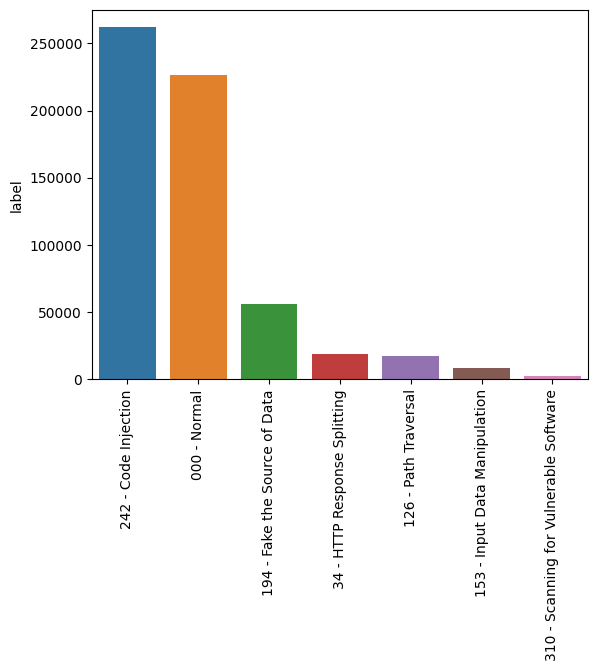

In [ ]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [ ]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,text,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


In [ ]:
# TF-IDF + NB
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8774839472794863


In [ ]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.81      0.93      0.87     45353
                  126 - Path Traversal       1.00      0.78      0.88      3504
         153 - Input Data Manipulation       0.15      0.19      0.17      1600
         194 - Fake the Source of Data       0.98      0.92      0.95     11298
                  242 - Code Injection       0.95      0.85      0.89     52342
310 - Scanning for Vulnerable Software       0.96      0.32      0.48       480
          34 - HTTP Response Splitting       0.95      0.94      0.95      3783

                              accuracy                           0.88    118360
                             macro avg       0.83      0.70      0.74    118360
                          weighted avg       0.89      0.88      0.88    118360

Confusion Matrix: 
 [[42395    10   430    41  2286     5   186]
 [  622  2743    33    85    21     0     0]
 [ 1033

In [ ]:
## TF-IDF + RF
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9599019939168638


In [ ]:
y_predict = rf.predict(test_features)

In [ ]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.92      0.99      0.96     45353
                  126 - Path Traversal       1.00      0.92      0.96      3504
         153 - Input Data Manipulation       0.48      0.20      0.28      1600
         194 - Fake the Source of Data       1.00      0.93      0.96     11298
                  242 - Code Injection       0.99      0.96      0.98     52342
310 - Scanning for Vulnerable Software       0.88      0.98      0.93       480
          34 - HTTP Response Splitting       1.00      1.00      1.00      3783

                              accuracy                           0.96    118360
                             macro avg       0.90      0.85      0.87    118360
                          weighted avg       0.96      0.96      0.96    118360

Confusion Matrix: 
 [[44992     3    45     4   270    39     0]
 [  227  3230    24     0    22     1     0]
 [ 1080

## Test for unseen data

In [ ]:
df_transfer = pd.read_csv('dataset_capec_transfer.csv')
df_transfer.head()

,text,label
0,POST /vendor/phpunit/phpunit/src/Util/PHP/eval...,153 - Input Data Manipulation
1,POST /cgi-bin/ViewLog.asp remote_submit_Flag=...,153 - Input Data Manipulation
2,GET /.svn/wc.db,153 - Input Data Manipulation
3,GET /blog/.svn/wc.db,153 - Input Data Manipulation
4,GET /blog/index.php/my-account/.svn/wc.db,153 - Input Data Manipulation


In [ ]:
df_transfer.label.unique()

array(['153 - Input Data Manipulation', '242 - Code Injection',
       '126 - Path Traversal', '34 - HTTP Response Splitting'],
      dtype=object)

In [ ]:
# Optional (not effect very much)
df_transfer['text'] = df_transfer['text'].str.replace('/',' ')
df_transfer.head()

,text,label
0,POST vendor phpunit phpunit src Util PHP eval...,153 - Input Data Manipulation
1,POST cgi-bin ViewLog.asp remote_submit_Flag=...,153 - Input Data Manipulation
2,GET .svn wc.db,153 - Input Data Manipulation
3,GET blog .svn wc.db,153 - Input Data Manipulation
4,GET blog index.php my-account .svn wc.db,153 - Input Data Manipulation


In [ ]:
vec = TfidfVectorizer(analyzer='word', input='content', max_features=300)
transfer_feature = vec.fit_transform(df_transfer['text']).toarray()

In [ ]:
y_transfer = df_transfer['label']

### 153 bị nhầm nhiều với 242, 126 cũng bị nhầm nhiều với 242 (có nên đổi label của 153 và 126 thành 242?)

In [ ]:
y_predict = mnb.predict(transfer_feature)
print(classification_report(y_transfer,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_transfer, y_predict))

                               precision    recall  f1-score   support

                 000 - Normal       0.00      0.00      0.00         0
         126 - Path Traversal       0.00      0.00      0.00       167
153 - Input Data Manipulation       0.00      0.00      0.00      1950
194 - Fake the Source of Data       0.00      0.00      0.00         0
         242 - Code Injection       0.83      0.89      0.86      9168
 34 - HTTP Response Splitting       0.58      0.39      0.46       534

                     accuracy                           0.70     11819
                    macro avg       0.23      0.21      0.22     11819
                 weighted avg       0.67      0.70      0.69     11819

Confusion Matrix: 
 [[   0    0    0    0    0    0]
 [  13    0    0   11  143    0]
 [ 568    0    0   86 1283   13]
 [   0    0    0    0    0    0]
 [ 802    0    4  104 8119  139]
 [  84    2    2    3  236  207]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rf.score(transfer_feature, y_transfer))

0.3943650054996193


## 126 bị nhầm nhiều với 242, 194 bị nhầm nhiều với 310, 34 bị nhầm nhiều với 194

In [ ]:
y_predict = rf.predict(transfer_feature)
print(classification_report(y_transfer,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_transfer, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00         0
                  126 - Path Traversal       0.06      0.11      0.08       167
         153 - Input Data Manipulation       0.81      0.10      0.18      1950
         194 - Fake the Source of Data       0.00      0.00      0.00         0
                  242 - Code Injection       0.95      0.49      0.64      9168
310 - Scanning for Vulnerable Software       0.00      0.00      0.00         0
          34 - HTTP Response Splitting       0.02      0.01      0.01       534

                              accuracy                           0.39     11819
                             macro avg       0.26      0.10      0.13     11819
                          weighted avg       0.87      0.39      0.53     11819

Confusion Matrix: 
 [[   0    0    0    0    0    0    0]
 [  12   18    0    9   96   32    0]
 [ 547   16  192  100

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Deep Neural Nets

In [ ]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

In [ ]:
## Reduce data for testing
df_242 = df_train[(df_train['label'] == '242 - Code Injection')]
df_242 = df_242.sample(frac = 1)
df_242 = df_242[:50000]
df_000 = df_train[(df_train['label'] == '000 - Normal')]
df_000 = df_000.sample(frac = 1)
df_000 = df_000[:50000]

In [ ]:
df_sub = df_train[(df_train['label'] != '000 - Normal') & (df_train['label'] != '242 - Code Injection')]

In [ ]:
df_train = pd.concat([df_train,df_242,df_000], ignore_index=True)

In [ ]:
possible_labels = df_train.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'000 - Normal': 0,
 '126 - Path Traversal': 1,
 '242 - Code Injection': 2,
 '153 - Input Data Manipulation': 3,
 '310 - Scanning for Vulnerable Software': 4,
 '194 - Fake the Source of Data': 5,
 '34 - HTTP Response Splitting': 6}

In [ ]:
df_train['label_int'] = df_train.label.replace(label_dict)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label_int"],
                                                  test_size=0.2,
                                                  shuffle=True)

w2v = Word2Vec([sentence.lower().split() for sentence in x_train.values])

maxlen = 100
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_sequences, 
                                maxlen=100,
                                padding='post',
                                truncating='post')

x_test = pad_sequences(x_test_sequences,
                             maxlen=100,
                             padding='post',
                             truncating='post')

embedding_matrix = np.zeros((len(word_index)+1, 100))
for word,i in word_index.items():
    try:
        embedding_matrix[i] = w2v.wv[i]
    except:
        embedding_matrix[i] = np.zeros(100)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=100,
        weights=[embedding_matrix]),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', metrics=['acc'], 
        loss='sparse_categorical_crossentropy')

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

Epoch 1/2
17295/17295 [==============================] - 219s 12ms/step - loss: 0.5177 - acc: 0.7780 - val_loss: 0.0984 - val_acc: 0.9726
Epoch 2/2
17295/17295 [==============================] - 177s 10ms/step - loss: 0.0906 - acc: 0.9742 - val_loss: 0.0874 - val_acc: 0.9752


In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("acc: ", results[1])

1081/1081 [==============================] - 5s 5ms/step - loss: 0.0874 - acc: 0.9752
acc:  0.975216805934906


In [ ]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]



In [ ]:
from sklearn.metrics import classification_report

y_pred = predict_class(x_test)

print(classification_report(y_test, y_pred))

4324/4324 [==============================] - 14s 3ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     55476
           1       0.98      0.96      0.97      3523
           2       0.99      0.98      0.99     62300
           3       0.87      0.34      0.49      1702
           4       0.94      0.96      0.95       478
           5       1.00      0.93      0.96     11083
           6       1.00      1.00      1.00      3798

    accuracy                           0.98    138360
   macro avg       0.96      0.88      0.91    138360
weighted avg       0.98      0.98      0.97    138360



In [ ]:
df_transfer['int_label'] = 0

In [ ]:
w2v = Word2Vec([sentence.lower().split() for sentence in df_transfer['text'].values])

maxlen = 100
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_transfer['text'])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

x_train_sequences = tokenizer.texts_to_sequences(df_transfer['text'])

x_transfer = pad_sequences(x_train_sequences, 
                                maxlen=100,
                                padding='post',
                                truncating='post')

In [ ]:
print(1 - model.evaluate(x_transfer, df_transfer['int_label'], batch_size=128)[1])

95/95 [==============================] - 1s 8ms/step - loss: 7.3830 - acc: 0.1557
0.8442886620759964
